# Updated baseline

## Data and imports

In [1]:
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm_notebook
import os, datetime

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.animation as animation

import IPython
from IPython.display import display, HTML

import sys
sys.path.append("../../models/new_baseline")

from model.model import *
from model.model_presets import BASELINE_MODEL, HIGH_MOVEMENT

## Scenario

**Sample**: 4,200 participants from 1,147 households.<br>
**Total (est.)**: 10,053 individuals from 2,351 households.


1. **Outer forest**: Lowest exposure, mostly through work
    - **N**: 3060 sample; 7324 est. pop. (density = 73%)
    - **PCR positivity**: 4.48%
2. **Fringe forest**: Middle exposure, through travel/work
    - N: 625 sample; 1496 est. pop. (density = 15%)
    - **PCR positivity**: 10.24%
4. **Inner forest**: Highest constant exposure
    - N: 515 sample; 1233 est. pop. (density = 12%)
    - **PCR positivity**: 28.74%

In the below table, "original" refers to the original parameters used in the model described by Manore et al. (2015)

| **Parameter** | **Interpretation** | **Value** | **Justification** |
|---------------|--------------------|-----------|-------------------|
|       $k$        |        Number of patches/regions            |    $3$       | Three regions |
|        $\Delta t$       |            Timestep in the model        |      $2\text{ hours}$     | Higher granularity for movement model <br/> (compared to original's 6-hour timestep) |
|      $\vec{\sigma_h}$         |        Maximum mosquito bites in a day            |    Original     | Nothing region-specific that <br/> alters exposed human surface area |
|       $\vec{\sigma_v}$        |        Maximum mosquito bite demand per day            |  Original         | Nothing region-specific that <br/> alters mosquito aggressiveness |
|   $\vec{K_v}$   |     Mosquito carrying capacity     |    $[10{\small,}000; 20{\small,}000; 50{\small,}000]$   | Arbitrary - scaled up 10x due to roughly same <br/> scale-up from 1,500 original agents; and forest-y <br/> patches have higher mosquito populations due to <br/> supporting environmental conditions |
|  $\text{patch densities}$    |    Density of locations (nodes) per patch      |   $[.85; .08; .07]$    | Derived from population figures <br/> across regions |
|   $\vec{\psi_v}$   |  Emergence rate of mosquitoes per patch  |  Original   | <mark>Does forest affect emergence rate of mosquitoes?</mark> |
|  $\vec{\beta_{hv}}$    |  Probability of mosquito-human transmission   |  Original  | - |
|  $\vec{\beta_{vh}}$    |  Probability of human-mosquito transmission   |  Original  | - |
| $\vec{\nu_v}$ | Mosquito exposed to infected rate | Original | - |
| $\vec{\mu_v}$ | Mosquito death rate | Original | - |
| $\text{number of locations}$ | - | 2,351 | - |
| $\text{number of agents}$ | - | 10,053 | - |
| $\text{initial infected}$ | Proportion of pop. initially infected | 0.005 | - |
| $\text{time}$ | Total time of simulation | 200 days | - |

In [16]:
NEW_BASELINE_MODEL = {
    "k" : 3,
    "timestep" : (2/24),
    "movement_dist" : lambda : np.random.lognormal(-1999/4000000, np.sqrt(np.log(1.001))),
    "sigma_h_arr" : np.array([19, 19, 19]),
    "sigma_v_arr" : np.array([.5, .5, .5]),
    "K_v_arr" : np.array([10_000, 20_000, 50_000]),
    "patch_densities" : np.array([.73, .15, .12]),
    "phi_v_arr" : np.array([.3, .3, .3]), # TESTING THIS AS IS
    "beta_hv_arr" : np.array([.33, .33, .33]),
    "beta_vh_arr" : np.array([.33, .33, .33]),
    "nu_v_arr" : np.array([.1, .1, .1]),
    "mu_v_arr" : np.array([1/14, 1/14, 1/14]),
    "num_locations" : 2_351,
    "edge_prob" : .03,
    "num_agents" : 10_053,
    "initial_infect_proportion" : .005,
    "mu_h_dist" : lambda : np.random.lognormal(-1.79226, np.sqrt(np.log(1.001))),
    "nu_h_dist" : lambda : np.random.lognormal(-1.60994, np.sqrt(np.log(1.001))),
    "total_time" : 200,
    "mosquito_timestep" : .005,
    "adopt_prob": 0,
    "r_v_arr": [],
}

In [28]:
m = BaselineModel(**NEW_BASELINE_MODEL)
data, _ = m.run(with_progress=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2400/2400 [01:28<00:00, 27.00it/s]


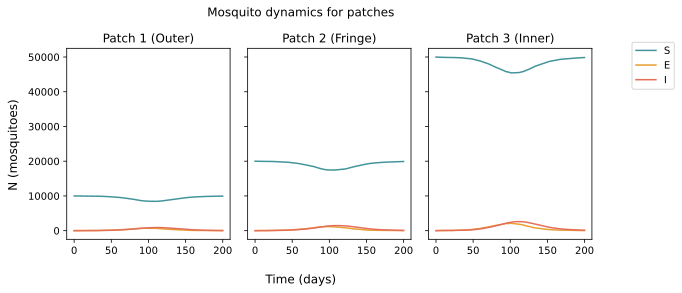

In [29]:
names = ["Patch 1 (Outer)", "Patch 2 (Fringe)", "Patch 3 (Inner)"]
labels= ["S", "E", "I"]

fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(8.5,4))
cur_name = 0

for i, col in enumerate(axs):
    for j, c, l in zip(range(len(axs)), ["#41949A", "#e79f31", "#E56E5A", "#7384BB"], labels):
        if i == 0:
            axs[i].plot(np.arange(0, m.total_time, m.timestep), data["patch_sei"][i].T[j], color=c, label=l)
        else:
            axs[i].plot(np.arange(0, m.total_time, m.timestep), data["patch_sei"][i].T[j], color=c)
#     for (i, color, args) in zip(range(3), range(1,4), ["steelblue", "green", "red"], [{}, {"marker": "o", "markevery": 15}, {"linestyle": "dashed"}]):
#         sns.kdeplot(peak_infection_times[temp_names[cur_name]][patch], ax=col, bw_adjust=.5, color=color, label=f"Patch {name}" if cur_name == 0 else None, **args)

#     col.set_xlim(0,200)
    
#     col.set_xlabel("")
#     col.set_ylabel("")

    col.set_title(names[i])
    
#     cur_name += 1

fig.suptitle("Mosquito dynamics for patches")

fig.supxlabel("Time (days)")
fig.supylabel("N (mosquitoes)")
fig.legend(bbox_to_anchor=[1.12, 0.875])
fig.tight_layout()

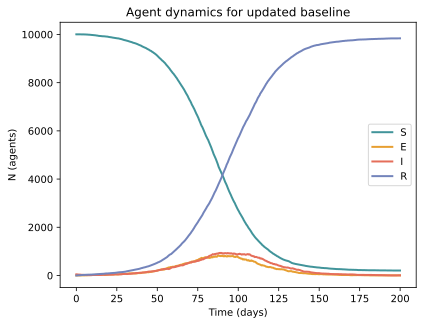

In [30]:
for j, c in zip(range(4), ["#41949A", "#e79f31", "#E56E5A", "#7384BB"]):
    plt.plot(np.arange(0, m.total_time, m.timestep), data["agent_disease_counts"][j], color=c, lw=2, label=(labels+["R"])[j])
plt.xlabel("Time (days)")
plt.ylabel("N (agents)")
plt.title("Agent dynamics for updated baseline")
plt.legend()
plt.show()